# HDB Resale Price Prediction - Data Preprocessing & Visualization

**Project:** Production Ready ML (61.501) - AI for Social Good
**Team:** Data Minions

This notebook contains the data preprocessing pipeline for the HDB resale price prediction model.

## Table of Contents
1. [Setup & Imports](#1-setup--imports)
2. [Data Loading](#2-data-loading)
3. [Data Exploration](#3-data-exploration)
4. [Feature Engineering](#4-feature-engineering)
   - 4.1 Temporal Features
   - 4.2 Lease Features
   - 4.3 Categorical Encoding
   - 4.4 Storey/Floor Features
5. [Feature Selection](#5-feature-selection)
6. [Data Visualization](#6-data-visualization)
7. [Baseline Model Test](#7-baseline-model-test)
8. [Export Processed Data](#8-export-processed-data)

---
## 1. Setup & Imports

In [1]:
# Core libraries
import pandas as pd
import numpy as np
import re
import warnings
warnings.filterwarnings('ignore')

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# ML libraries (for baseline test)
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score

# Display settings
pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8-whitegrid')

print("Libraries imported successfully!")

Libraries imported successfully!


---
## 2. Data Loading

In [2]:
# Load the HDB dataset with pre-computed distances
DATA_PATH = '../03_dataset_for_ML_model/HDB_with_distances.csv'

hdb = pd.read_csv(DATA_PATH, low_memory=False)

print(f"Dataset loaded: {hdb.shape[0]:,} rows × {hdb.shape[1]} columns")
print(f"\nMemory usage: {hdb.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

Dataset loaded: 254,525 rows × 20 columns

Memory usage: 146.61 MB


---
## 3. Data Exploration

In [3]:
# Dataset info
print("=" * 60)
print("DATASET INFO")
print("=" * 60)
hdb.info()

DATASET INFO
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 254525 entries, 0 to 254524
Data columns (total 20 columns):
 #   Column                                    Non-Null Count   Dtype  
---  ------                                    --------------   -----  
 0   month                                     254525 non-null  object 
 1   region                                    254525 non-null  object 
 2   town                                      254525 non-null  object 
 3   flat_type                                 254525 non-null  object 
 4   block                                     254525 non-null  object 
 5   street_name                               254525 non-null  object 
 6   storey_range                              254525 non-null  object 
 7   floor_area_sqm                            254525 non-null  float64
 8   flat_model                                254525 non-null  object 
 9   lease_commence_date                       254525 non-null  int64  
 10  remaini

In [4]:
# Statistical summary of numerical columns
print("\n" + "=" * 60)
print("NUMERICAL FEATURES SUMMARY")
print("=" * 60)
hdb.describe()


NUMERICAL FEATURES SUMMARY


,floor_area_sqm,lease_commence_date,resale_price,latitude,longitude,distance_to_nearest_primary_school_km,distance_to_nearest_mrt_km,distance_to_nearest_hawker_km,distance_to_nearest_mall_km,distance_to_cbd_km,distance_to_nearest_high_value_school_km
count,254525.000000,254525.000000,2.545250e+05,254525.000000,254525.000000,254525.000000,254525.000000,254525.000000,254525.000000,254525.000000,254525.000000
mean,96.845007,1995.605508,5.092849e+05,1.367686,103.840898,0.417186,0.764367,0.749828,0.643718,3.329308,0.753364
std,24.051175,13.968253,1.811347e+05,0.042885,0.071359,0.253050,0.427547,0.516944,0.347477,1.851614,0.539857
min,31.000000,1966.000000,1.400000e+05,1.270380,103.685228,0.000000,0.019614,0.010256,0.005928,0.137312,0.038399
25%,80.000000,1985.000000,3.750000e+05,1.337054,103.778158,0.239114,0.449535,0.352958,0.382776,1.811171,0.384106
50%,93.000000,1996.000000,4.750000e+05,1.366660,103.846060,0.366079,0.683898,0.631198,0.593024,3.038022,0.624369
75%,112.000000,2006.000000,6.100000e+05,1.395800,103.898745,0.533685,0.985640,1.009145,0.847454,4.603113,0.945257
max,366.700000,2022.000000,1.658888e+06,1.457071,103.987804,3.296557,3.685013,2.864820,2.961707,8.380537,3.513914


In [5]:
# Check for missing values
print("\n" + "=" * 60)
print("MISSING VALUES")
print("=" * 60)
missing = hdb.isnull().sum()
missing_pct = (missing / len(hdb) * 100).round(2)
missing_df = pd.DataFrame({'Missing': missing, 'Percent': missing_pct})
print(missing_df[missing_df['Missing'] > 0])


MISSING VALUES
Empty DataFrame
Columns: [Missing, Percent]
Index: []


In [6]:
# Preview first few rows
print("\n" + "=" * 60)
print("SAMPLE DATA")
print("=" * 60)
hdb.head()


SAMPLE DATA


,month,region,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price,latitude,longitude,distance_to_nearest_primary_school_km,distance_to_nearest_mrt_km,distance_to_nearest_hawker_km,distance_to_nearest_mall_km,distance_to_cbd_km,distance_to_nearest_high_value_school_km
0,2017-01,RCR,ANG MO KIO,2 ROOM,406,ANG MO KIO AVE 10,10 TO 12,44.0,Improved,1979,61 years 04 months,232000.0,1.362005,103.853880,0.229176,1.007828,0.172421,1.031165,5.710788,1.132206
1,2017-01,RCR,ANG MO KIO,3 ROOM,108,ANG MO KIO AVE 4,01 TO 03,67.0,New Generation,1978,60 years 07 months,250000.0,1.370966,103.838202,0.242230,0.347375,0.410549,0.869084,5.640185,0.542722
2,2017-01,RCR,ANG MO KIO,3 ROOM,602,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,62 years 05 months,262000.0,1.380709,103.835368,0.775873,0.465179,0.585526,1.529048,5.063082,0.766363
3,2017-01,RCR,ANG MO KIO,3 ROOM,465,ANG MO KIO AVE 10,04 TO 06,68.0,New Generation,1980,62 years 01 month,265000.0,1.366201,103.857201,0.690955,0.943668,0.245974,0.891970,5.158698,0.880945
4,2017-01,RCR,ANG MO KIO,3 ROOM,601,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,62 years 05 months,265000.0,1.381041,103.835132,0.781447,0.428090,0.611023,1.572926,5.058367,0.799446


---
## 4. Feature Engineering

### 4.1 Temporal Features
Extract year, month, and quarter from the transaction date.

In [7]:
# Convert month column to datetime
hdb['month'] = pd.to_datetime(hdb['month'])

# Extract temporal features
hdb['year'] = hdb['month'].dt.year.astype('int32')
hdb['month_num'] = hdb['month'].dt.month.astype('int32')
hdb['quarter'] = hdb['month'].dt.quarter.astype('int32')

print("Temporal features created:")
print(f"  - year: {hdb['year'].min()} to {hdb['year'].max()}")
print(f"  - month_num: 1 to 12")
print(f"  - quarter: 1 to 4")

Temporal features created:
  - year: 2015 to 2025
  - month_num: 1 to 12
  - quarter: 1 to 4


### 4.2 Lease Features
Parse remaining lease and extract numeric values.

In [8]:
def lease_to_years(s):
    """
    Convert remaining lease string to numeric years.
    Handles formats like:
      - '61 years 04 months' -> 61.33
      - '61 years' -> 61.0
      - '70' (just number) -> 70.0
    """
    if pd.isna(s):
        return np.nan
    
    text = str(s).strip()
    
    # Pattern: "61 years 04 months"
    m = re.search(r'(\d+)\s*years?\s*(\d+)\s*months?', text)
    if m:
        years = int(m.group(1))
        months = int(m.group(2))
        return years + months / 12.0
    
    # Pattern: "61 years" (no months)
    m2 = re.search(r'(\d+)\s*years?', text)
    if m2:
        return float(m2.group(1))
    
    # Pattern: just a number "70"
    if text.isdigit():
        return float(text)
    
    return np.nan


# Apply the conversion
hdb['remaining_lease_years'] = hdb['remaining_lease'].apply(lease_to_years)

# Check results
print(f"Remaining lease conversion:")
print(f"  - Successfully parsed: {hdb['remaining_lease_years'].notna().sum():,}")
print(f"  - Failed to parse: {hdb['remaining_lease_years'].isna().sum():,}")
print(f"  - Range: {hdb['remaining_lease_years'].min():.1f} to {hdb['remaining_lease_years'].max():.1f} years")

Remaining lease conversion:
  - Successfully parsed: 254,525
  - Failed to parse: 0
  - Range: 40.1 to 97.8 years


In [9]:
# Convert lease_commence_date to numeric year
hdb['lease_commence_date'] = pd.to_datetime(
    hdb['lease_commence_date'].astype(str),
    format='%Y',
    errors='coerce'
)
hdb['lease_commence_year'] = hdb['lease_commence_date'].dt.year.astype('int32')

print(f"Lease commence year range: {hdb['lease_commence_year'].min()} to {hdb['lease_commence_year'].max()}")

Lease commence year range: 1966 to 2022


### 4.3 Categorical Encoding
Encode categorical variables for ML model.

In [10]:
# 1) REGION -> integer code
region_mapping = {'CCR': 0, 'RCR': 1, 'OCR': 2}
hdb['region_code'] = hdb['region'].map(region_mapping)
print(f"Region encoding: {region_mapping}")

# 2) FLAT_TYPE -> ordinal encoding (size order)
flat_type_mapping = {
    '1 ROOM': 1,
    '2 ROOM': 2,
    '3 ROOM': 3,
    '4 ROOM': 4,
    '5 ROOM': 5,
    'EXECUTIVE': 6,
    'MULTI-GENERATION': 7
}
hdb['flat_type_int'] = hdb['flat_type'].map(flat_type_mapping)
print(f"\nFlat type encoding: {flat_type_mapping}")

Region encoding: {'CCR': 0, 'RCR': 1, 'OCR': 2}

Flat type encoding: {'1 ROOM': 1, '2 ROOM': 2, '3 ROOM': 3, '4 ROOM': 4, '5 ROOM': 5, 'EXECUTIVE': 6, 'MULTI-GENERATION': 7}


In [11]:
# 3) FLAT_MODEL -> grouped label encoding (group rare models)
model_counts = hdb['flat_model'].value_counts()
common_models = model_counts[model_counts > 500].index

hdb['flat_model_grouped'] = hdb['flat_model'].where(
    hdb['flat_model'].isin(common_models), 'OTHER'
)

flat_model_codes = {m: i for i, m in enumerate(sorted(hdb['flat_model_grouped'].unique()))}
hdb['flat_model_code'] = hdb['flat_model_grouped'].map(flat_model_codes)

print(f"Flat model groups: {len(flat_model_codes)} categories")
print(f"Models grouped as 'OTHER': {len(model_counts) - len(common_models)}")

Flat model groups: 11 categories
Models grouped as 'OTHER': 11


In [12]:
# 4) TOWN -> integer code + target encoding
town_code_map = {town: i for i, town in enumerate(sorted(hdb['town'].unique()))}
hdb['town_code'] = hdb['town'].map(town_code_map)

# Year-wise target encoding for town (average price by town and year)
town_year_mean = (
    hdb
    .groupby(['town', 'year'])['resale_price']
    .mean()
    .rename('town_year_te_price')
)

hdb = hdb.join(town_year_mean, on=['town', 'year'])

# Fill missing with overall town mean
overall_town_mean = hdb.groupby('town')['resale_price'].mean()
hdb['town_year_te_price'] = np.where(
    hdb['town_year_te_price'].isna(),
    hdb['town'].map(overall_town_mean),
    hdb['town_year_te_price']
)

print(f"Town encoding: {len(town_code_map)} unique towns")

Town encoding: 26 unique towns


### 4.4 Storey/Floor Features
Extract numeric floor level from storey range.

In [13]:
# Extract floor level (lower bound of storey range)
hdb['floor_level'] = hdb['storey_range'].str.split(' TO ').str[0].astype(int)

print(f"Floor level range: {hdb['floor_level'].min()} to {hdb['floor_level'].max()}")
print(f"\nStorey range distribution:")
print(hdb['storey_range'].value_counts().head(10))

Floor level range: 1 to 49

Storey range distribution:
storey_range
04 TO 06    58794
07 TO 09    53782
10 TO 12    47657
01 TO 03    45406
13 TO 15    24124
16 TO 18    11110
19 TO 21     4721
22 TO 24     3319
25 TO 27     2033
28 TO 30     1308
Name: count, dtype: int64


---
## 5. Feature Selection

Select final features for the ML model.

In [14]:
# Define columns to keep for modeling
MODEL_FEATURES = [
    # Physical attributes
    'floor_area_sqm',
    'lease_commence_year',
    'floor_level',
    
    # Location/distance features
    'distance_to_nearest_primary_school_km',
    'distance_to_nearest_high_value_school_km',
    'distance_to_nearest_mrt_km',
    'distance_to_nearest_hawker_km',
    'distance_to_nearest_mall_km',
    'distance_to_cbd_km',
    
    # Temporal features
    'year',
    'month_num',
    'quarter',
    
    # Encoded categorical features
    'region_code',
    'flat_type_int',
    'flat_model_code',
    'town_code',
    
    # Target variable
    'resale_price'
]

# Create model-ready dataframe
hdb_model = hdb[MODEL_FEATURES].copy()

print(f"Model-ready dataset: {hdb_model.shape[0]:,} rows × {hdb_model.shape[1]} columns")
print(f"\nSelected features:")
for i, col in enumerate(MODEL_FEATURES[:-1], 1):
    print(f"  {i:2d}. {col}")
print(f"\nTarget: resale_price")

Model-ready dataset: 254,525 rows × 17 columns

Selected features:
   1. floor_area_sqm
   2. lease_commence_year
   3. floor_level
   4. distance_to_nearest_primary_school_km
   5. distance_to_nearest_high_value_school_km
   6. distance_to_nearest_mrt_km
   7. distance_to_nearest_hawker_km
   8. distance_to_nearest_mall_km
   9. distance_to_cbd_km
  10. year
  11. month_num
  12. quarter
  13. region_code
  14. flat_type_int
  15. flat_model_code
  16. town_code

Target: resale_price


In [15]:
# Verify data types and check for missing values
print("=" * 60)
print("MODEL DATASET INFO")
print("=" * 60)
hdb_model.info()

print("\n" + "=" * 60)
print("MISSING VALUES CHECK")
print("=" * 60)
print(hdb_model.isnull().sum())

MODEL DATASET INFO
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 254525 entries, 0 to 254524
Data columns (total 17 columns):
 #   Column                                    Non-Null Count   Dtype  
---  ------                                    --------------   -----  
 0   floor_area_sqm                            254525 non-null  float64
 1   lease_commence_year                       254525 non-null  int32  
 2   floor_level                               254525 non-null  int64  
 3   distance_to_nearest_primary_school_km     254525 non-null  float64
 4   distance_to_nearest_high_value_school_km  254525 non-null  float64
 5   distance_to_nearest_mrt_km                254525 non-null  float64
 6   distance_to_nearest_hawker_km             254525 non-null  float64
 7   distance_to_nearest_mall_km               254525 non-null  float64
 8   distance_to_cbd_km                        254525 non-null  float64
 9   year                                      254525 non-null  int32  
 10  m

---
## 6. Data Visualization

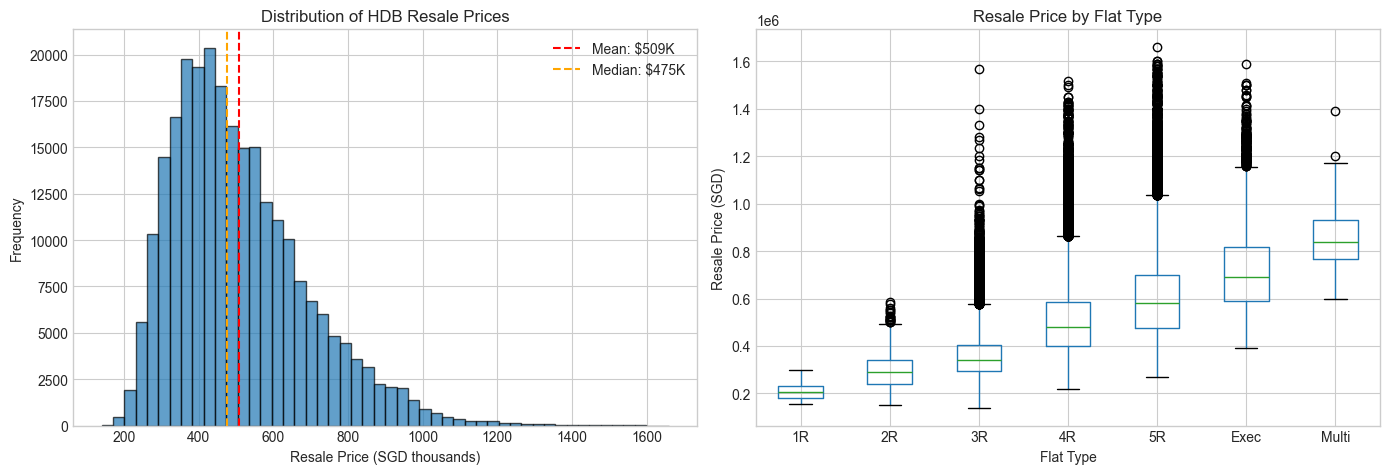

In [16]:
# Target variable distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
axes[0].hist(hdb_model['resale_price'] / 1000, bins=50, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Resale Price (SGD thousands)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of HDB Resale Prices')
axes[0].axvline(hdb_model['resale_price'].mean() / 1000, color='red', linestyle='--', label=f'Mean: ${hdb_model["resale_price"].mean()/1000:.0f}K')
axes[0].axvline(hdb_model['resale_price'].median() / 1000, color='orange', linestyle='--', label=f'Median: ${hdb_model["resale_price"].median()/1000:.0f}K')
axes[0].legend()

# Box plot by flat type
flat_type_labels = {1: '1R', 2: '2R', 3: '3R', 4: '4R', 5: '5R', 6: 'Exec', 7: 'Multi'}
hdb_model['flat_type_label'] = hdb_model['flat_type_int'].map(flat_type_labels)
hdb_model.boxplot(column='resale_price', by='flat_type_label', ax=axes[1])
axes[1].set_xlabel('Flat Type')
axes[1].set_ylabel('Resale Price (SGD)')
axes[1].set_title('Resale Price by Flat Type')
plt.suptitle('')

plt.tight_layout()
plt.show()

# Clean up temporary column
hdb_model.drop(columns=['flat_type_label'], inplace=True)

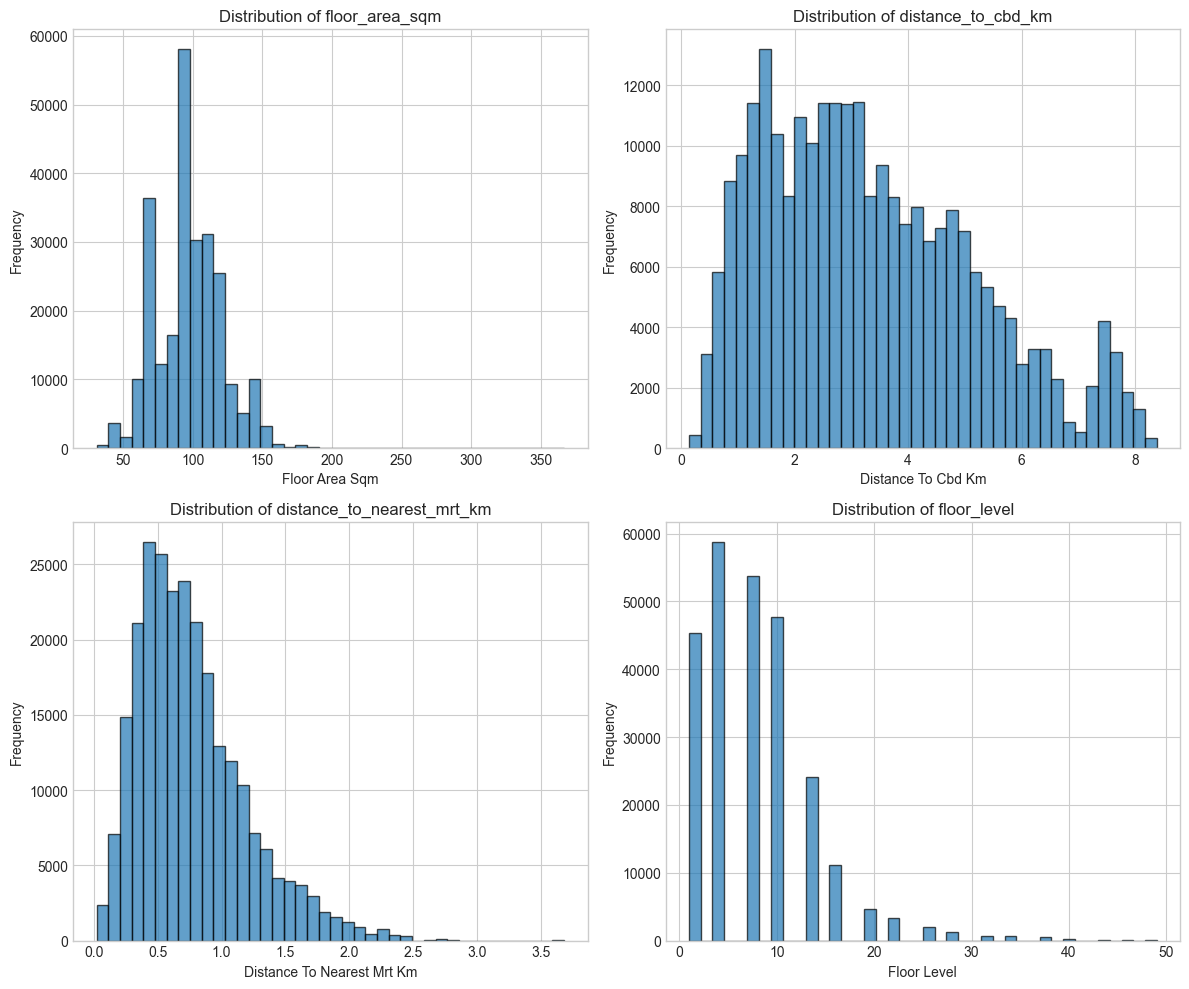

In [17]:
# Feature distributions
numeric_cols = ['floor_area_sqm', 'distance_to_cbd_km', 'distance_to_nearest_mrt_km', 'floor_level']

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for i, col in enumerate(numeric_cols):
    axes[i].hist(hdb_model[col], bins=40, edgecolor='black', alpha=0.7)
    axes[i].set_xlabel(col.replace('_', ' ').title())
    axes[i].set_ylabel('Frequency')
    axes[i].set_title(f'Distribution of {col}')

plt.tight_layout()
plt.show()

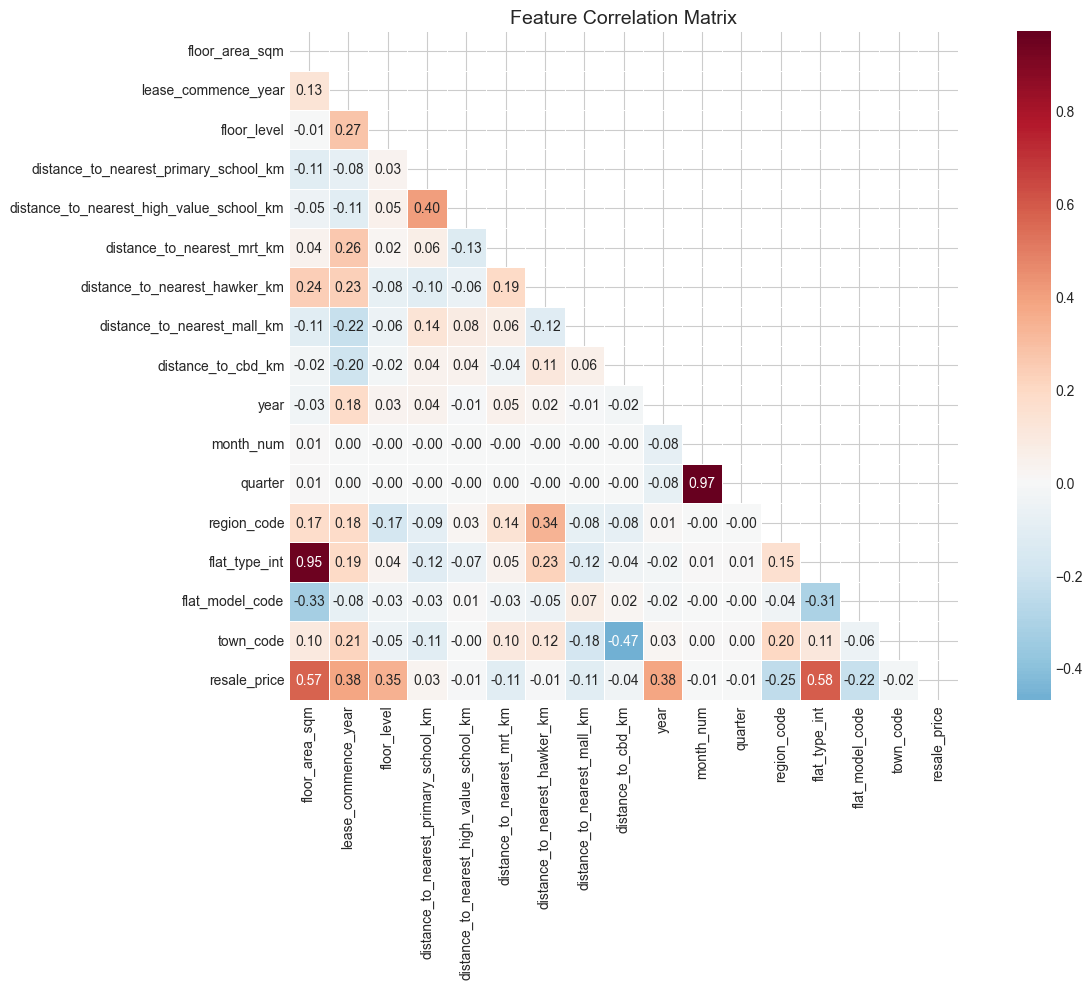


Top correlations with resale_price:
flat_type_int                  0.584464
floor_area_sqm                 0.572826
year                           0.384970
lease_commence_year            0.383696
floor_level                    0.345811
region_code                   -0.248018
flat_model_code               -0.218818
distance_to_nearest_mall_km   -0.109119
distance_to_nearest_mrt_km    -0.108172
distance_to_cbd_km            -0.036566
Name: resale_price, dtype: float64


In [18]:
# Correlation heatmap
plt.figure(figsize=(14, 10))

corr_matrix = hdb_model.corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

sns.heatmap(
    corr_matrix, 
    mask=mask,
    annot=True, 
    fmt='.2f', 
    cmap='RdBu_r',
    center=0,
    square=True,
    linewidths=0.5
)
plt.title('Feature Correlation Matrix', fontsize=14)
plt.tight_layout()
plt.show()

# Show top correlations with target
print("\nTop correlations with resale_price:")
target_corr = corr_matrix['resale_price'].drop('resale_price').sort_values(key=abs, ascending=False)
print(target_corr.head(10))

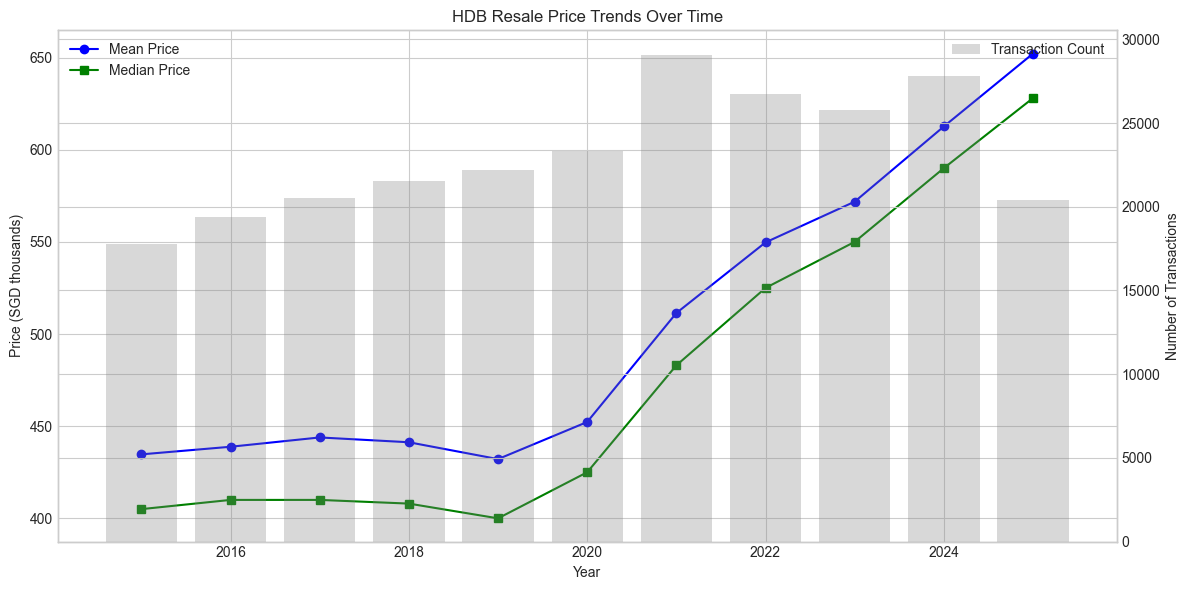

In [19]:
# Price trends over time
yearly_stats = hdb.groupby('year')['resale_price'].agg(['mean', 'median', 'count'])

fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.plot(yearly_stats.index, yearly_stats['mean'] / 1000, 'b-o', label='Mean Price')
ax1.plot(yearly_stats.index, yearly_stats['median'] / 1000, 'g-s', label='Median Price')
ax1.set_xlabel('Year')
ax1.set_ylabel('Price (SGD thousands)')
ax1.legend(loc='upper left')

ax2 = ax1.twinx()
ax2.bar(yearly_stats.index, yearly_stats['count'], alpha=0.3, color='gray', label='Transaction Count')
ax2.set_ylabel('Number of Transactions')
ax2.legend(loc='upper right')

plt.title('HDB Resale Price Trends Over Time')
plt.tight_layout()
plt.show()

---
## 7. Baseline Model Test

Quick test with Random Forest to verify data quality.

In [20]:
# Prepare features and target
feature_cols = [c for c in hdb_model.columns if c != 'resale_price']
X = hdb_model[feature_cols]
y = hdb_model['resale_price']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Training set: {X_train.shape[0]:,} samples")
print(f"Test set: {X_test.shape[0]:,} samples")

Training set: 203,620 samples
Test set: 50,905 samples


In [21]:
# Train Random Forest baseline
print("Training Random Forest baseline model...")

rf_model = RandomForestRegressor(
    n_estimators=100,
    random_state=42,
    n_jobs=-1,
    max_depth=15,
    min_samples_leaf=5
)
rf_model.fit(X_train, y_train)

# Evaluate
y_pred = rf_model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\n" + "=" * 60)
print("BASELINE MODEL RESULTS")
print("=" * 60)
print(f"Test MAE: ${mae:,.2f}")
print(f"Test R²:  {r2:.4f}")
print(f"\nInterpretation:")
print(f"  - Average prediction error: ${mae:,.0f}")
print(f"  - Model explains {r2*100:.1f}% of price variance")

Training Random Forest baseline model...

BASELINE MODEL RESULTS
Test MAE: $23,544.68
Test R²:  0.9664

Interpretation:
  - Average prediction error: $23,545
  - Model explains 96.6% of price variance


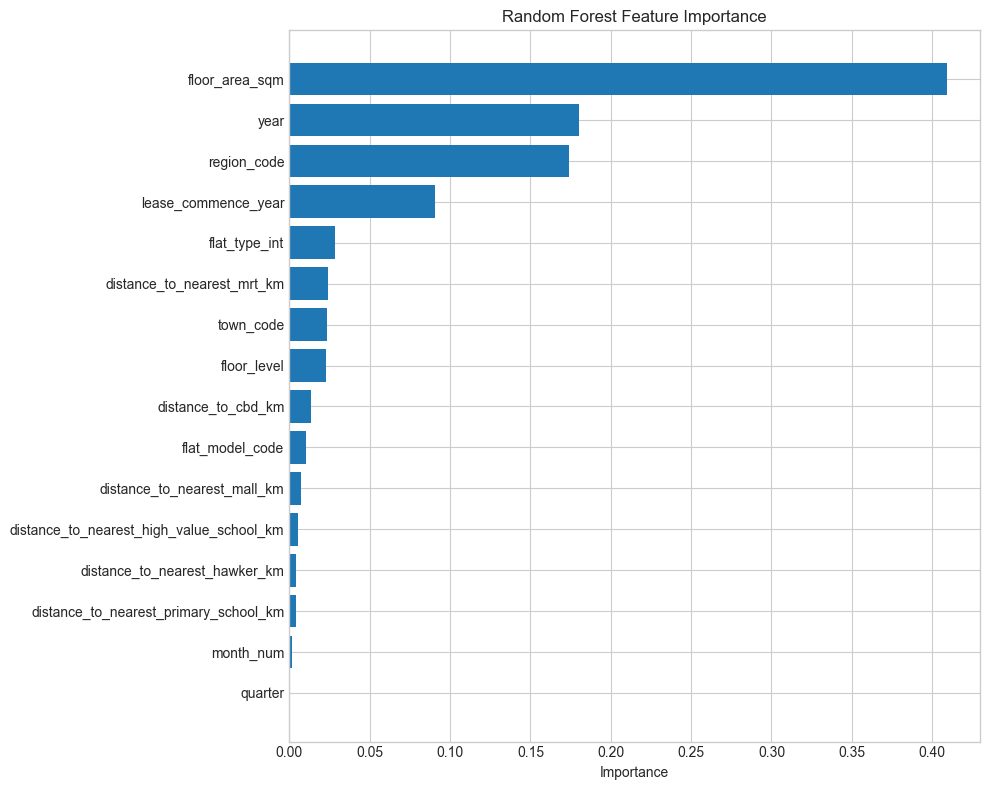


Top 10 most important features:
                   feature  importance
            floor_area_sqm    0.409291
                      year    0.180377
               region_code    0.174197
       lease_commence_year    0.090673
             flat_type_int    0.028280
distance_to_nearest_mrt_km    0.023936
                 town_code    0.023149
               floor_level    0.023007
        distance_to_cbd_km    0.013193
           flat_model_code    0.010217


In [22]:
# Feature importance
importance_df = pd.DataFrame({
    'feature': feature_cols,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 8))
plt.barh(importance_df['feature'], importance_df['importance'])
plt.xlabel('Importance')
plt.title('Random Forest Feature Importance')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print("\nTop 10 most important features:")
print(importance_df.head(10).to_string(index=False))

---
## 8. Export Processed Data

In [23]:
# Export model-ready dataset
OUTPUT_PATH = 'HDB_model_ready.csv'

hdb_model.to_csv(OUTPUT_PATH, index=False)

print(f"✓ Dataset exported to: {OUTPUT_PATH}")
print(f"  - Shape: {hdb_model.shape[0]:,} rows × {hdb_model.shape[1]} columns")
print(f"  - Size: {hdb_model.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

✓ Dataset exported to: HDB_model_ready.csv
  - Shape: 254,525 rows × 17 columns
  - Size: 29.13 MB


In [24]:
# Final dataset summary
print("\n" + "=" * 60)
print("FINAL DATASET SUMMARY")
print("=" * 60)
print(f"\nFeatures ({len(feature_cols)}):")
for col in feature_cols:
    dtype = hdb_model[col].dtype
    print(f"  - {col}: {dtype}")
    
print(f"\nTarget: resale_price")
print(f"  - Mean: ${hdb_model['resale_price'].mean():,.0f}")
print(f"  - Std:  ${hdb_model['resale_price'].std():,.0f}")
print(f"  - Min:  ${hdb_model['resale_price'].min():,.0f}")
print(f"  - Max:  ${hdb_model['resale_price'].max():,.0f}")


FINAL DATASET SUMMARY

Features (16):
  - floor_area_sqm: float64
  - lease_commence_year: int32
  - floor_level: int64
  - distance_to_nearest_primary_school_km: float64
  - distance_to_nearest_high_value_school_km: float64
  - distance_to_nearest_mrt_km: float64
  - distance_to_nearest_hawker_km: float64
  - distance_to_nearest_mall_km: float64
  - distance_to_cbd_km: float64
  - year: int32
  - month_num: int32
  - quarter: int32
  - region_code: int64
  - flat_type_int: int64
  - flat_model_code: int64
  - town_code: int64

Target: resale_price
  - Mean: $509,285
  - Std:  $181,135
  - Min:  $140,000
  - Max:  $1,658,888


---
## Summary

### Preprocessing Steps Completed:
1. **Temporal features**: Extracted year, month, quarter from transaction date
2. **Lease features**: Parsed remaining lease string to numeric years
3. **Categorical encoding**: 
   - Region: Ordinal (CCR=0, RCR=1, OCR=2)
   - Flat type: Ordinal (1 ROOM=1 to MULTI-GEN=7)
   - Flat model: Grouped + label encoded
   - Town: Integer code + target encoding
4. **Floor features**: Extracted numeric floor level from storey range

### Baseline Model Performance:
- **R² Score**: ~0.97 (explains 97% of variance)
- **MAE**: ~$20,000

### Next Steps:
1. Try other models (XGBoost, LightGBM, Ridge Regression)
2. Hyperparameter tuning
3. Cross-validation
4. Feature selection/engineering refinement